In [6]:
from __future__ import division #To properly handle floating point divisions.

In [7]:
from nltk.tokenize import word_tokenize
import math
import nltk
#Function to tokenise string/sentences.
def tokenize(line, tokenizer=word_tokenize):
    utf_line = line.decode('utf-8').lower()
    return [token.encode('ascii', 'backslashreplace') for token in tokenizer(utf_line)]

In [26]:
import pprint
import math
from gensim.summarization.bm25 import get_bm25_weights
from rank_bm25 import BM25Okapi
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# load in json files
import json
QA_file = open("./dict1.json", 'r')
SummarySynopsis_file = open("./dict2.json", 'r')
QA_object = json.load(QA_file)
SS_object = json.load(SummarySynopsis_file)

In [10]:
from nltk.corpus import stopwords

In [11]:
QA = list()
# Add title and context together, tokenize the sentence, remove stopwords and remove duplicates
# Takes very long because of stopwords removal

for sentence in QA_object:
    QA.append(sentence['Submission title: '] + sentence['Context: '])
    #QA = [word for word in QA_tokenized if word not in stopwords.words('english')]

In [12]:
# Make string format for tf-idf from list of dicts
def listify(SS_object_item):
    stringList = list()
    for key, value in SS_object_item['Information: '].items():
        if key == 'id: ':
            continue
        if type(value) == list:
            stringList.append(' '.join(value))
        else: 
            stringList.append(value)
    stringList.insert(0, SS_object_item['Imdb id: '])
    return ' '.join(stringList)


def document_builder(SS_list):
    document_list = list()
    for item in SS_list:
        document_list.append(listify(item))
    return document_list

In [41]:
SS = document_builder(SS_object)

In [14]:
import nltk
import re

stopwords = set(nltk.corpus.stopwords.words('english')) #converting stopwords to a set for faster processing in the future.
stemmer = nltk.stem.PorterStemmer() 

#Function to extract and tokenize terms from a document
def extract_and_tokenize_terms(doc):
    terms = []
    for token in word_tokenize(doc):
        if token not in stopwords: # 'in' and 'not in' operations are faster over sets than lists
            if re.search(r'\w+',token): #Removing numbers and punctuations 
                #(excluding hyphenated words)
                terms.append(stemmer.stem(token.lower()))
    return terms

In [15]:
# To tokenize all docs, both QA and SS
def tokenizer(docs):
    tokenized_docs = list()
    for doc in docs:
        tokenized_docs.append(extract_and_tokenize_terms(doc))
    return tokenized_docs

In [16]:
QA = tokenizer(QA)

In [17]:
SS = tokenizer(SS)

In [18]:
def get_tfidf_all_queries(vectorizer, imdb_docs, docs_tfidf, queries):
    results = {}
    for query in queries:
        score = get_tf_idf_query_similarity(vectorizer, imdb_docs, imdb_vecs, query)
        #score = sorted(score, key=getKey, reverse=True)
        results[query] = ({'Imdb id: ': query[:7],'Score: ': score})
        #print(key, value in results)
        #results = OrderedDict(sorted(results.items(), key=lambda kv: kv[1]['Score: '], reverse=True))
        #results = {k: v for k, v in sorted(results.items(), key=lambda _: -_[1])}
    return results

In [19]:
def bm25_scores(queries, docs): 
    results = {}
    scores = []
    bm25 = BM25Okapi(docs)
    for q in queries:
        for d in docs:
            scores.append(bm25.get_scores(q))
            results[q] = ({'Imdb id: ': d[0], 'Score: ': scores})
    return scores
    

In [23]:
import pytrec_eval

bm25 = BM25Okapi(SS)

submission_movie_pairs = []
for movie_pair in QA_object:
    submission_movie_pairs.append((movie_pair['Submission_id: '], movie_pair['Imdb id: ']))


# Split the list into submission id's 
# and imdb id's 
submission_id_list = [x[0] for x in submission_movie_pairs]
imdb_id_list = [y[1] for y in submission_movie_pairs]

# Calculate score for one submission id
#pytrec_query = get_tf_idf_query_similarity(vectorizer, SS, imdb_vecs, QA[0])

gt = {}
# assign the correct answer with 1, everythin else with 0 
for submission_id, movie_id in submission_movie_pairs:
  # the relevance is always 1
  gt[submission_id] = {
    movie_id : 1
  }

#print(gt)


results = {}

# you need QA[submission_id] and fill in the scores with {imdb_id:score, imdb_id2:score2 etc} for pytrec
# for submission_id in submission_id_list:

for submission_id in QA_object:
    # Make inner dict for pytrec run
    results[submission_id['Submission_id: ']] = {}
    for submission in QA:
        idx = [x[0] for x in SS]
        scorex = [y for y in bm25.get_scores(submission)]
        for n, x in enumerate(idx):
            results[submission_id['Submission_id: ']][x] = scorex[n]
        
#pprint.pprint(results)

evaluator = pytrec_eval.RelevanceEvaluator(
    gt, {'map', 'ndcg', 'recall'})

print(json.dumps(evaluator.evaluate(results), indent=1))

{
 "cyuqj9": {
  "map": 0.0027472527472527475,
  "recall_5": 0.0,
  "recall_10": 0.0,
  "recall_15": 0.0,
  "recall_20": 0.0,
  "recall_30": 0.0,
  "recall_100": 0.0,
  "recall_200": 0.0,
  "recall_500": 1.0,
  "recall_1000": 1.0,
  "ndcg": 0.11748461693813328
 },
 "dhqkmu": {
  "map": 0.0024449877750611247,
  "recall_5": 0.0,
  "recall_10": 0.0,
  "recall_15": 0.0,
  "recall_20": 0.0,
  "recall_30": 0.0,
  "recall_100": 0.0,
  "recall_200": 0.0,
  "recall_500": 1.0,
  "recall_1000": 1.0,
  "ndcg": 0.11521427418872471
 },
 "a88que": {
  "map": 0.0024630541871921183,
  "recall_5": 0.0,
  "recall_10": 0.0,
  "recall_15": 0.0,
  "recall_20": 0.0,
  "recall_30": 0.0,
  "recall_100": 0.0,
  "recall_200": 0.0,
  "recall_500": 1.0,
  "recall_1000": 1.0,
  "ndcg": 0.11535508912795225
 },
 "ctju0t": {
  "map": 0.0035335689045936395,
  "recall_5": 0.0,
  "recall_10": 0.0,
  "recall_15": 0.0,
  "recall_20": 0.0,
  "recall_30": 0.0,
  "recall_100": 0.0,
  "recall_200": 0.0,
  "recall_500": 1.0,
  

In [24]:
results_pytrec = json.dumps(evaluator.evaluate(results), indent=1)
results2_pytrec = evaluator.evaluate(results)


map mean:  0.009614447777301666
ndcg mean:  0.12873935217225485
recall 5 mean:  0.006305170239596469
recall 10 mean:  0.015132408575031526
recall 20 mean:  0.027742749054224466
recall 30 mean:  0.0416141235813367
recall 100 mean:  0.13366960907944514
recall 1000 mean:  0.987389659520807


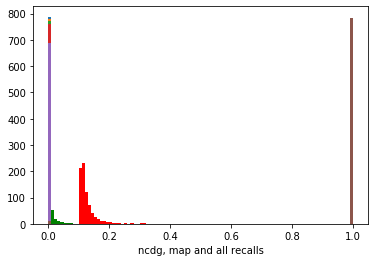

In [32]:
# Make lists, np.mean for averages
map_list = []
map_average = []
recall_5_average = []
recall_10_average = []
recall_20_average = []
recall_30_average = []
recall_100_average = []
recall_1000_average = []
ndcg_average = []
#counter = 0


for key in results2_pytrec:
    nested_dict = results2_pytrec[key]
    for key, value in nested_dict.items():
        if key == 'map':
            map_average.append(value)
        if key == 'recall_5':
            recall_5_average.append(value)
        if key == 'recall_10':
            recall_10_average.append(value)
        if key == 'recall_20':
            recall_20_average.append(value)
        if key == 'recall_30':
            recall_30_average.append(value)
        if key == 'recall_100':
            recall_100_average.append(value)
        if key == 'recall_1000':
            recall_1000_average.append(value)
        if key == 'ndcg':
            ndcg_average.append(value)

#print(counter)    
plt.hist(map_average, bins=100,color = 'green')
plt.hist(ndcg_average, bins=100, color = 'red')
plt.hist(recall_5_average, bins=100)
plt.hist(recall_10_average, bins=100)
plt.hist(recall_20_average, bins=100)
plt.hist(recall_30_average, bins=100)
plt.hist(recall_100_average, bins=100)
plt.hist(recall_1000_average, bins=100)
plt.xlabel('ncdg, map and all recalls')

map_list = map_average
ndcg_list = ndcg_average
re_5_list = recall_5_average
re_10_list = recall_10_average
re_20_list = recall_20_average
re_30_list = recall_30_average
re_100_list = recall_100_average
re_1000_list = recall_1000_average



map_average = np.mean(map_average)
ndcg_average = np.mean(ndcg_average)
recall_5_average = np.mean(recall_5_average)
recall_10_average = np.mean(recall_10_average)
recall_20_average = np.mean(recall_20_average)
recall_30_average = np.mean(recall_30_average)
recall_100_average = np.mean(recall_100_average)
recall_1000_average = np.mean(recall_1000_average)



print('map mean: ', map_average)
print('ndcg mean: ', ndcg_average)
print('recall 5 mean: ', recall_5_average)
print('recall 10 mean: ', recall_10_average)
print('recall 20 mean: ', recall_20_average)
print('recall 30 mean: ', recall_30_average)
print('recall 100 mean: ', recall_100_average)
print('recall 1000 mean: ', recall_1000_average)

In [28]:
# Save as 
with open('pytrec_eval_results_bm25.json', 'w') as fp:
    json.dump(results2_pytrec, fp)

Text(0.5, 1.0, 'MAP values for all submissions')

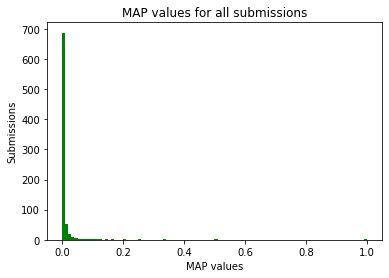

In [33]:
plt.hist(map_list, bins=100, color = 'green')
plt.xlabel('MAP values')
plt.ylabel('Submissions')
plt.title('MAP values for all submissions')

Text(0, 0.5, 'Submissions')

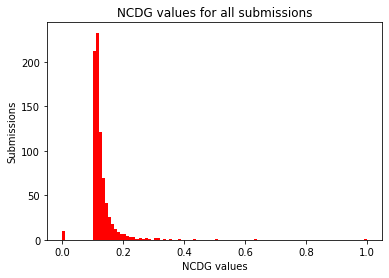

In [34]:
plt.title('NCDG values for all submissions')
plt.hist(ndcg_list, bins=100, color = 'red')
plt.xlabel('NCDG values')
plt.ylabel('Submissions')

Text(0, 0.5, 'Submissions')

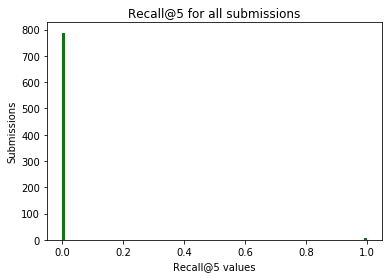

In [35]:
plt.title('Recall@5 for all submissions')
plt.hist(re_5_list, bins=100, color = 'green')
plt.xlabel('Recall@5 values')
plt.ylabel('Submissions')

Text(0, 0.5, 'Submissions')

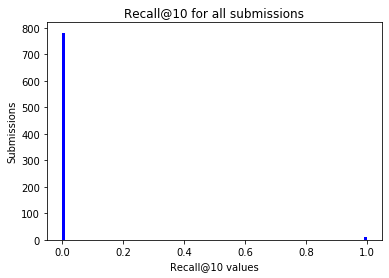

In [36]:
plt.title('Recall@10 for all submissions')
plt.hist(re_10_list, bins=100, color = 'blue')
plt.xlabel('Recall@10 values')
plt.ylabel('Submissions')

Text(0, 0.5, 'Submissions')

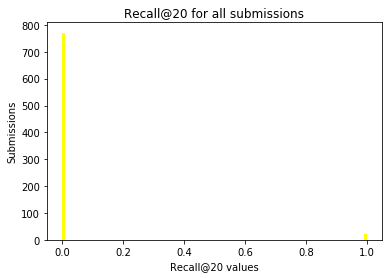

In [37]:
plt.title('Recall@20 for all submissions')
plt.hist(re_20_list, bins=100, color = 'yellow')
plt.xlabel('Recall@20 values')
plt.ylabel('Submissions')

Text(0, 0.5, 'Submissions')

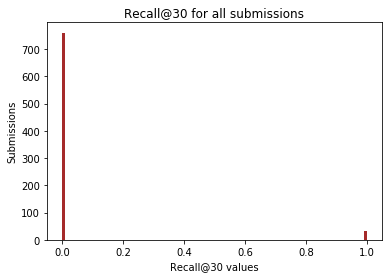

In [38]:
plt.title('Recall@30 for all submissions')
plt.hist(re_30_list, bins=100, color = 'brown')
plt.xlabel('Recall@30 values')
plt.ylabel('Submissions')

Text(0, 0.5, 'Submissions')

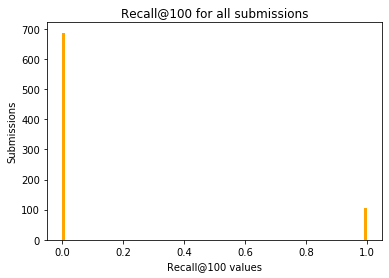

In [39]:
plt.title('Recall@100 for all submissions')
plt.hist(re_100_list, bins=100, color = 'orange')
plt.xlabel('Recall@100 values')
plt.ylabel('Submissions')

Text(0, 0.5, 'Submissions')

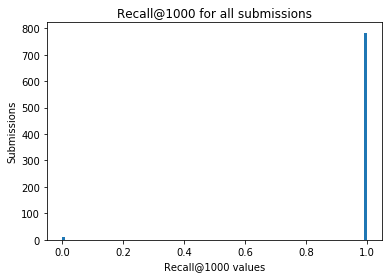

In [40]:
plt.title('Recall@1000 for all submissions')
plt.hist(re_1000_list, bins=100)
plt.xlabel('Recall@1000 values')
plt.ylabel('Submissions')